### Step1: assign cell label

this is the testing code, run `step1_crop_10K0.py`-`step1_crop_10K5.py` to obtain the results for this step.

in each panel, only keep cells with one centriod! (based on z=0)\
only keep cells with cell seg at all panels

Z - number of z panels

In [71]:
import numpy as np
import pandas as pd
import anndata
import matplotlib.pyplot as plt
import pickle
import scipy.stats as stats
from collections import defaultdict
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import random
import math
import timeit
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
pd.options.mode.chained_assignment = None  # default='warn'
from collections import Counter

red = '#c0362c'
lightgreen = '#93c572'
darkgreen = '#4c9141'
lightblue = '#5d8aa8'
darkblue = '#2e589c'
white = '#fafafa'
lightgray = '#d3d3d3'
darkgray ='#545454'
lightorange = '#fabc2e'
darkorange = '#fb9912'
yellow = '#e4d00a'

color_list = [red, darkorange, lightorange, lightgreen, lightblue]

#### select an experiment
based on the paper, mouse2 seems better

In [1]:
experiment_name = '220501_wb3_co2_15_5z18R_merfish5'

#### load expr data of an experiment

In [ ]:
path = '/net/mulan/home/jadewang/data_new_merfish/processed_data/decoded_spots/mouse2_coronal/spots_'+experiment_name+'.csv'
expr_df = pd.read_csv(path)

In [4]:
expr_df.head()

barcode_id   global_x   global_y  global_z          x          y  fov  \
0           0  5357.7505 -818.14777       0.0  422.57350  105.15802    0   
1           0  5372.3877 -814.76746       0.0  556.86210  136.17009    0   
2           0  5368.3354 -812.59436       0.0  519.68180  156.10689    0   
3           0  5367.2110 -807.90784       0.0  509.36734  199.10252    0   
4           0  5361.4580 -806.18085       0.0  456.58624  214.94606    0   

  target_gene  
0         Grp  
1         Grp  
2         Grp  
3         Grp  
4         Grp

In [5]:
print(f'expr_df.shape {expr_df.shape}')
print(f'xmin={expr_df.x.min()} xmax={expr_df.x.max()}')
print(f'ymin={expr_df.y.min()} ymax={expr_df.y.max()}')
print(f'global xmin={expr_df.global_x.min()} xmax={expr_df.global_x.max()}')
print(f'global ymin={expr_df.global_y.min()} ymax={expr_df.global_y.max()}')
print(f'global z unique {expr_df.global_z.unique()}')
print(f'#fov {expr_df.fov.nunique()}')
print(f'#gene {expr_df.target_gene.nunique()}')

expr_df.shape (70866578, 8)
xmin=102.00001 xmax=1946.0
ymin=102.000015 ymax=1946.0
global xmin=-8154.6416 xmax=5523.803000000001
global ymin=-2420.6606 ymax=4382.496
global z unique [0. 1. 2. 3. 4.]
#fov 1374
#gene 1240


In [6]:
Z = expr_df.global_z.nunique()
print(f'Z={Z}')

Z=5


#### load cell seg

In [7]:
path = '/net/mulan/home/jadewang/data_new_merfish/processed_data/cell_boundaries/mouse2_coronal/'+experiment_name+'.csv'
seg_df = pd.read_csv(path)

In [8]:
seg_df.head()

Unnamed: 0  \
0   4195605887788691952135636853561851   
1   5780261735764654093526972708487477   
2   8643836582703002147825477715634495   
3  10506229852832348202834467311815748   
4  11176241328667876468223490547974940   

                                        boundaryX_z0  \
0  3250.893838056922, 3250.893838056922, 3250.893...   
1  -7246.938868483901, -7246.938868483901, -7246....   
2                                                NaN   
3  -2919.969110867381, -2919.969110867381, -2919....   
4  -5201.485869577527, -5201.485869577527, -5201....   

                                        boundaryY_z0  \
0  2744.462888389826, 2744.3538883924484, 2744.24...   
1  -1168.5700405836105, -1168.679040580988, -1168...   
2                                                NaN   
3  465.21998912096024, 465.11098912358284, 465.00...   
4  323.75300297141075, 323.64400297403336, 323.53...   

                                        boundaryX_z1  \
0  3247.6238381356, 3247.6238381356, 3247.6238381...   
1  -7247.592868468166, -7247.592868468166, -7247....   
2                                                NaN   
3  -2919.969110867381, -2919.969110867381, -2919....   
4  -5203.338869532943, -5203.338869532943, -5203....   

                                        boundaryY_z1  \
0  2747.4058883190155, 2747.296888321638, 2747.18...   
1  -1172.6030404865742, -1172.7120404839516, -117...   
2                                                NaN   
3  466.3099890947342, 466.2009890973568, 466.0919...   
4  326.26000291109085, 326.15100291371346, 326.04...   

                                        boundaryX_z2  \
0  3246.8608381539584, 3246.8608381539584, 3246.8...   
1  -7249.772868415714, -7249.772868415714, -7249....   
2                                                NaN   
3  -2919.642110875249, -2919.642110875249, -2919....   
4  -5203.665869525075, -5203.665869525075, -5203....   

                                        boundaryY_z2  \
0  2747.7328883111477, 2747.6238883137703, 2747.5...   
1  -1166.3900406360626, -1166.49904063344, -1166....   
2                                                NaN   
3  466.6369890868664, 466.527989089489, 466.41898...   
4  325.93300291895866, 325.82400292158127, 325.71...   

                                        boundaryX_z3  \
0  3246.8608381539584, 3246.8608381539584, 3246.8...   
1  -7249.4458684235815, -7249.4458684235815, -724...   
2  -2289.4491116017102, -2289.4491116017102, -228...   
3  -2919.642110875249, -2919.642110875249, -2919....   
4  -5203.9928695172075, -5203.9928695172075, -520...   

                                        boundaryY_z3  \
0  2747.4058883190155, 2747.296888321638, 2747.18...   
1  -1166.3900406360626, -1166.49904063344, -1166....   
2  765.6090172231197, 765.5000172257423, 765.3910...   
3  467.39998906850815, 467.29098907113075, 467.18...   
4  325.93300291895866, 325.82400292158127, 325.71...   

                                        boundaryX_z4  \
0  3250.56683806479, 3250.56683806479, 3250.56683...   
1  -7249.118868431449, -7249.118868431449, -7249....   
2  -2289.7761115938424, -2289.7761115938424, -228...   
3  -2919.3151108831166, -2919.3151108831166, -291...   
4  -5203.665869525075, -5203.665869525075, -5203....   

                                        boundaryY_z4  
0  2743.0458884239197, 2742.9368884265423, 2742.8...  
1  -1166.0630406439304, -1166.1720406413078, -116...  
2  765.6090172231197, 765.5000172257423, 765.3910...  
3  466.6369890868664, 466.527989089489, 466.41898...  
4  324.5160029530525, 324.4070029556751, 324.2980...

In [9]:
N = seg_df['Unnamed: 0'].nunique()
print(f'#cells={N}')

#cells=97265


#### load gene by cell mat

for cell centroid info

In [10]:
# load data
path = '/net/mulan/home/jadewang/data_new_merfish/processed_data/counts_mouse2_coronal.h5ad'
counts = anndata.read_h5ad(path)

path = '/net/mulan/home/jadewang/data_new_merfish/processed_data/raw_counts_mouse2_coronal.h5ad'
raw_counts = anndata.read_h5ad(path)

In [11]:
print(counts.X.shape)
print(counts.obs.shape)
counts.obs.head(3)

(4303411, 1147)
(4303411, 8)


fov       volume     center_x  \
cell_id                                                                  
12223463170972323880570633388623100411     1  1287.572660 -1822.948536   
169596288914017551896343595402592598295    1   516.074616 -1856.902035   
171398694098362222414006681552792435812    1   568.740532 -1842.023535   

                                            center_y    sample_id    slice_id  \
cell_id                                                                         
12223463170972323880570633388623100411  -6330.854562  co2_sample1  co2_slice1   
169596288914017551896343595402592598295 -6415.983560  co2_sample1  co2_slice1   
171398694098362222414006681552792435812 -6298.318063  co2_sample1  co2_slice1   

                                           fov_x    fov_y  
cell_id                                                    
12223463170972323880570633388623100411  -1890.91 -6482.31  
169596288914017551896343595402592598295 -1890.91 -6482.31  
171398694098362222414006681552792435812 -1890.91 -6482.31

#### plot a subregion

expr, seg, and center

In [12]:
x_len = 200
y_len = 200

plot_xmin = expr_df.global_x.min()+1000
plot_ymin = expr_df.global_y.min()+1000
plot_d_x = x_len
plot_d_y = y_len

In [13]:
plot_expr_df = expr_df[(expr_df.global_x > plot_xmin)
                      &(expr_df.global_y > plot_ymin)
                      &(expr_df.global_x < (plot_xmin+plot_d_x))
                      &(expr_df.global_y < (plot_ymin+plot_d_y))].copy()

In [14]:
plot_centroid = (counts.obs)[(counts.obs.sample_id=='co2_sample15')
                            &(counts.obs.center_x>plot_xmin)
                            &(counts.obs.center_y>plot_ymin)
                            &(counts.obs.center_x<(plot_xmin+plot_d_x))
                            &(counts.obs.center_y<(plot_ymin+plot_d_y))].copy()

In [15]:
plot_centroid.head()

fov      volume     center_x  \
cell_id                                                                  
101005951035859341263051146845716983231  1265  676.974239 -7152.843266   
176776081366502384871768594611046588131  1265  312.323198 -7133.059766   
18863229232942197740254094724772787577   1265  192.494913 -7096.108767   
191160368378583684055522474369390189701  1265  457.221164 -6971.467270   
101004992299866355972564746581389126762  1266  773.785968 -6960.894271   

                                            center_y     sample_id  \
cell_id                                                              
101005951035859341263051146845716983231 -1221.816539  co2_sample15   
176776081366502384871768594611046588131 -1222.852039  co2_sample15   
18863229232942197740254094724772787577  -1228.351089  co2_sample15   
191160368378583684055522474369390189701 -1227.424589  co2_sample15   
101004992299866355972564746581389126762 -1267.636043  co2_sample15   

                                            slice_id    fov_x    fov_y  
cell_id                                                                 
101005951035859341263051146845716983231  co2_slice89 -7165.76 -1231.79  
176776081366502384871768594611046588131  co2_slice89 -7165.76 -1231.79  
18863229232942197740254094724772787577   co2_slice89 -7165.76 -1231.79  
191160368378583684055522474369390189701  co2_slice89 -7165.76 -1231.79  
101004992299866355972564746581389126762  co2_slice89 -7165.76 -1431.79

In [16]:
plot_cell_id_ = plot_centroid.index.to_list()
print(len(plot_cell_id_))

85


In [17]:
plot_seg_df = seg_df[seg_df['Unnamed: 0'].isin(plot_cell_id_)].copy()
# remove rows with NA 
plot_seg_rm_na_df = plot_seg_df.dropna(axis='index')

In [18]:
plot_cell_id = plot_seg_rm_na_df['Unnamed: 0'].unique().tolist()
print(f'#cells to plot {len(plot_cell_id)}')

#cells to plot 55


In [19]:
plot_centroid_rm_na = plot_centroid[plot_centroid.index.isin(plot_cell_id)]

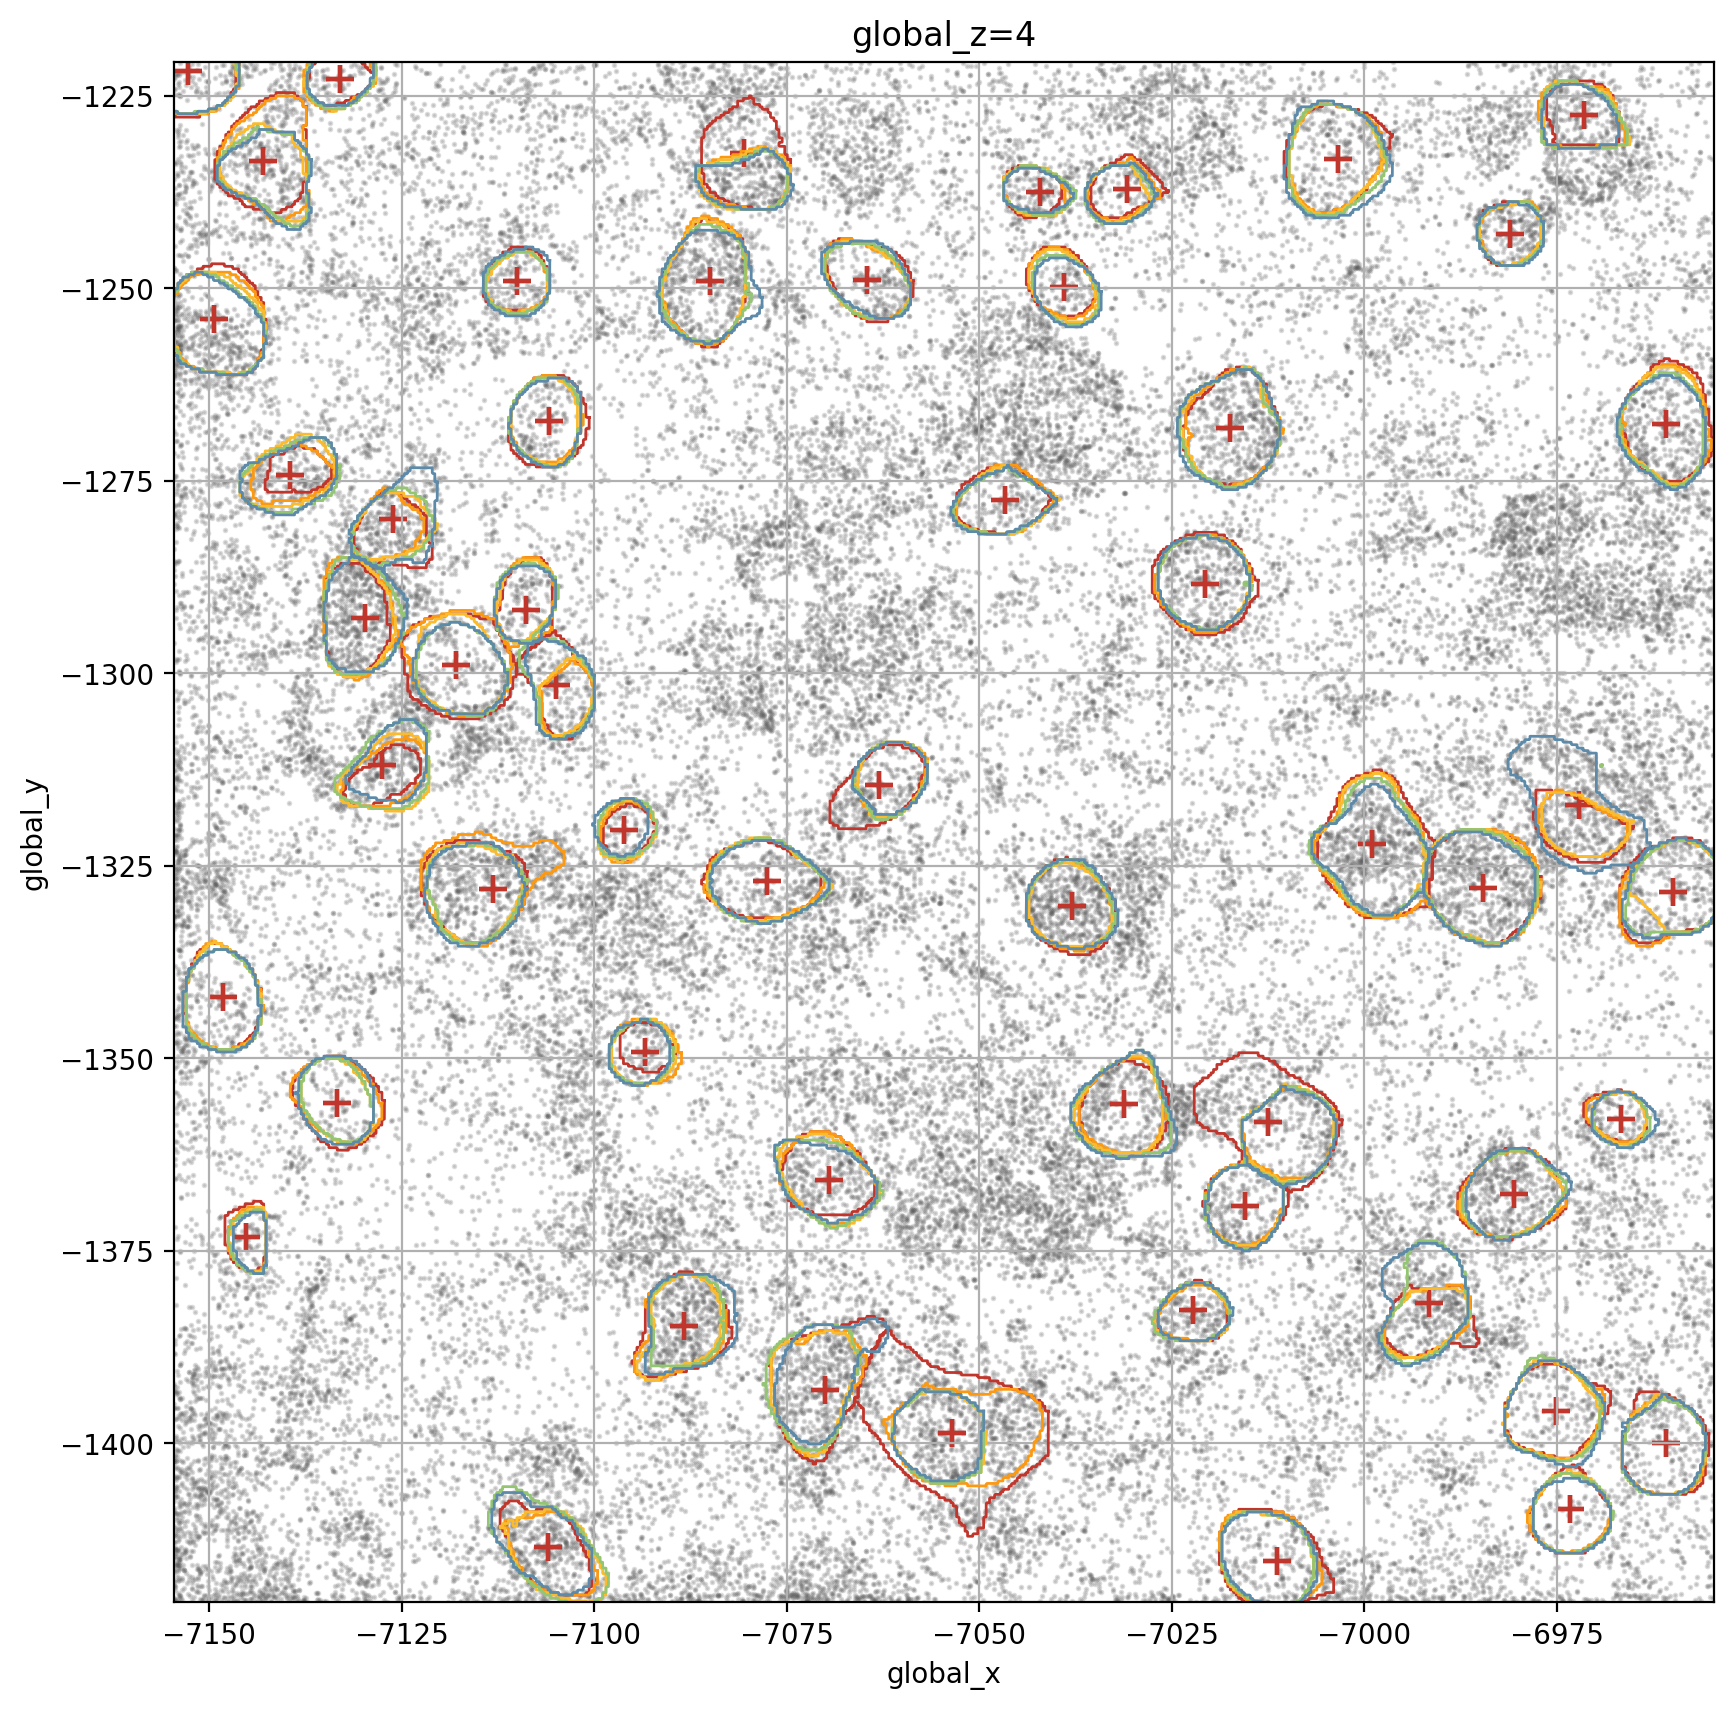

In [20]:
nr = 1
nc = 1
ss_nr = 10
ss_nc = 10
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=200)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.2, hspace=0.0)

for z in range(Z):
    ax = plt.subplot(gs[0,0])
    
    # expr
    plot_expr_df_z = plot_expr_df[plot_expr_df.global_z==z]
    ax.scatter(plot_expr_df_z.global_x,
               plot_expr_df_z.global_y,
               s=1, 
               color=darkgray,
               alpha=0.2)
    ax.set_xlim([plot_xmin, plot_xmin+plot_d_x])
    ax.set_ylim([plot_ymin, plot_ymin+plot_d_y])
    ax.set_xlabel('global_x')
    ax.set_ylabel('global_y')
    ax.set_title('global_z='+str(z))
    ax.grid()
    ax.set_aspect('equal', adjustable='box') 
    
    # seg
    for c in plot_cell_id:
        seg_df_c = plot_seg_df[plot_seg_df['Unnamed: 0']==c]
        cb_x_str = seg_df_c['boundaryX_z'+str(z)].iloc[0]
        cb_y_str = seg_df_c['boundaryY_z'+str(z)].iloc[0]
        if c in plot_cell_id:
            if isinstance(cb_x_str, str) or isinstance(cb_y_str, str): # if not NA
                cb_x = np.fromstring(cb_x_str, sep=',')
                cb_y = np.fromstring(cb_y_str, sep=',')
                ax.plot(cb_x, cb_y, lw=1, color=color_list[z])

    # centroid
    ax.scatter(plot_centroid_rm_na.center_x, 
               plot_centroid_rm_na.center_y, 
               marker='+',
               s = 100,
               color=red)

#### explore KL divergense of two segs

In [196]:
x_len = 200
y_len = 200

plot_xmin = expr_df.global_x.min()+1000
plot_ymin = expr_df.global_y.min()+1000
plot_d_x = x_len
plot_d_y = y_len

In [197]:
plot_expr_df = expr_df[(expr_df.global_x > plot_xmin)
                      &(expr_df.global_y > plot_ymin)
                      &(expr_df.global_x < (plot_xmin+plot_d_x))
                      &(expr_df.global_y < (plot_ymin+plot_d_y))].copy()

plot_centroid = (counts.obs)[(counts.obs.sample_id=='co2_sample15')
                            &(counts.obs.center_x>plot_xmin)
                            &(counts.obs.center_y>plot_ymin)
                            &(counts.obs.center_x<(plot_xmin+plot_d_x))
                            &(counts.obs.center_y<(plot_ymin+plot_d_y))].copy()

plot_cell_id_ = plot_centroid.index.to_list()
print(len(plot_cell_id_))

plot_seg_df = seg_df[seg_df['Unnamed: 0'].isin(plot_cell_id_)].copy()
# remove rows with NA 
plot_seg_rm_na_df = plot_seg_df.dropna(axis='index')

plot_cell_id = plot_seg_rm_na_df['Unnamed: 0'].unique().tolist()
print(f'#cells to plot {len(plot_cell_id)}')
print(plot_cell_id)

plot_centroid_rm_na = plot_centroid[plot_centroid.index.isin(plot_cell_id)]

85
#cells to plot 55
['1810650596759827040151245130999953356', '9442804310082367414053905209867889909', '17109828990261735992951736096257628387', '21122347258963602223711592480090420820', '24334684466327325144463334573715929538', '25202688288822581808888090698495348016', '41489771797273796881161584469779984523', '47455937979185622127607932027111272071', '51866826839617077913417227539899017211', '53908449933507915845810109713894836444', '74097991739137876227098920869453245680', '78694651983061672043960974508267857167', '86179583340465893534263832390654033964', '88623412181834480610148779620746929025', '93660086413666657872332135365593734005', '95993203230516971303593801615560254837', '101004992299866355972564746581389126762', '101005951035859341263051146845716983231', '104633327966064735165244038894714249372', '105070596113781200813279886659175521711', '106436320233951565632101133461870364840', '117058772309257829799447455580459162384', '117589354420412949044997203004897735557', '119023

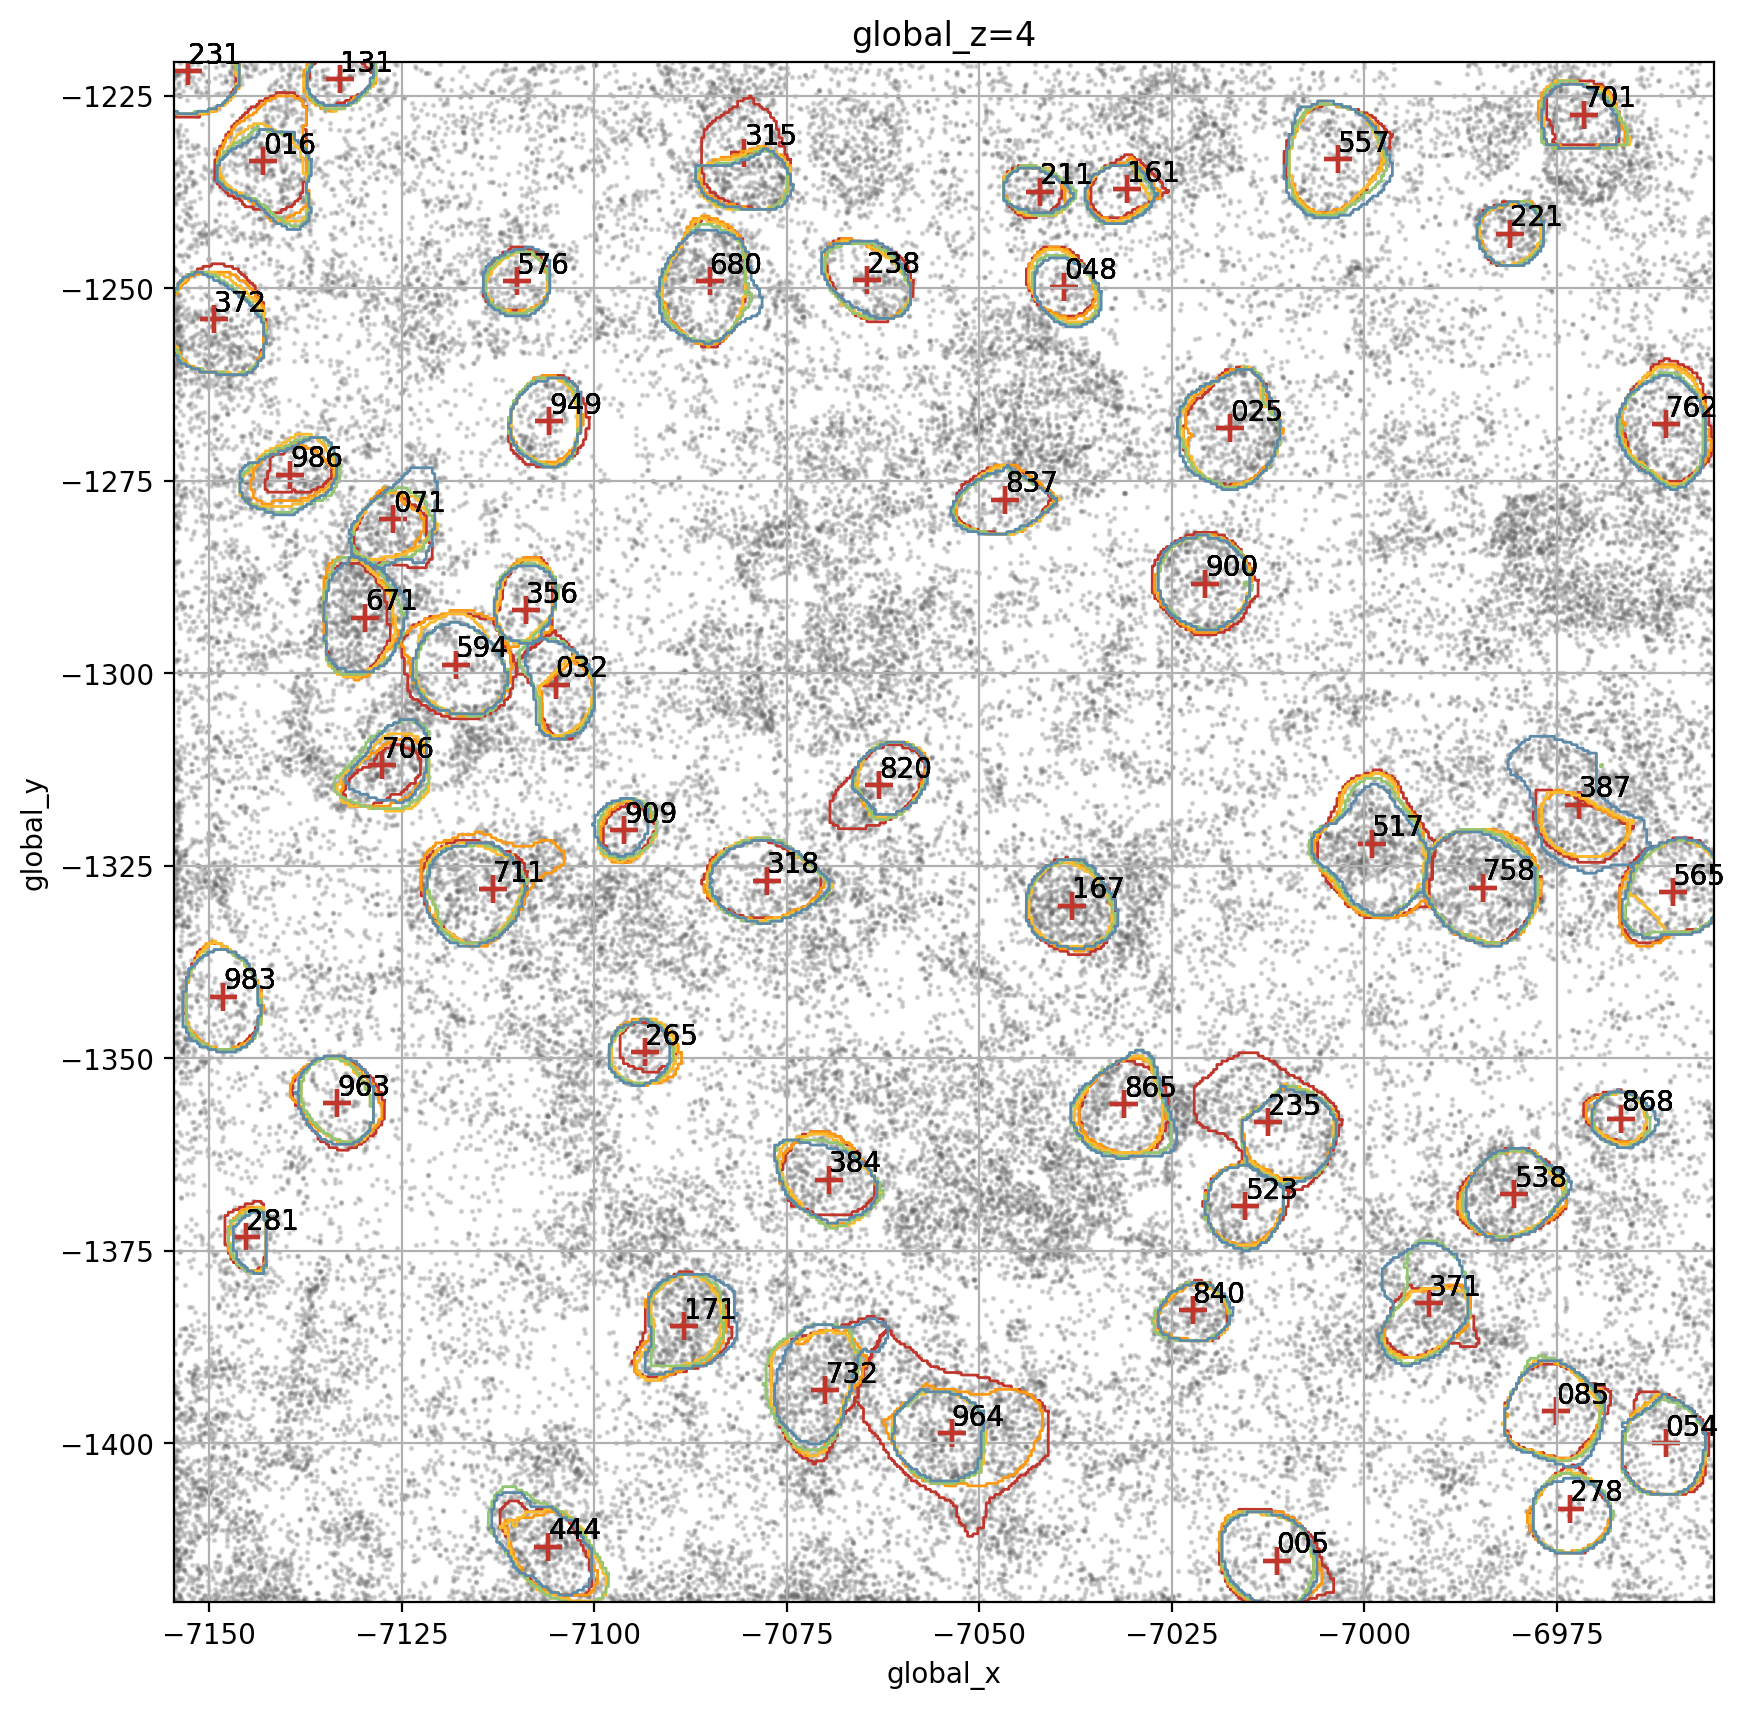

In [198]:
nr = 1
nc = 1
ss_nr = 10
ss_nc = 10
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=200)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.2, hspace=0.0)

for z in range(Z):
    ax = plt.subplot(gs[0,0])
    
    # expr
    plot_expr_df_z = plot_expr_df[plot_expr_df.global_z==z]
    ax.scatter(plot_expr_df_z.global_x,
               plot_expr_df_z.global_y,
               s=1, 
               color=darkgray,
               alpha=0.2)
    ax.set_xlim([plot_xmin, plot_xmin+plot_d_x])
    ax.set_ylim([plot_ymin, plot_ymin+plot_d_y])
    ax.set_xlabel('global_x')
    ax.set_ylabel('global_y')
    ax.set_title('global_z='+str(z))
    ax.grid()
    ax.set_aspect('equal', adjustable='box') 
    
    # seg
    for c in plot_cell_id[:]:
        seg_df_c = plot_seg_df[plot_seg_df['Unnamed: 0']==c]
        cb_x_str = seg_df_c['boundaryX_z'+str(z)].iloc[0]
        cb_y_str = seg_df_c['boundaryY_z'+str(z)].iloc[0]
        if c in plot_cell_id:
            if isinstance(cb_x_str, str) or isinstance(cb_y_str, str): # if not NA
                cb_x = np.fromstring(cb_x_str, sep=',')
                cb_y = np.fromstring(cb_y_str, sep=',')
                ax.plot(cb_x, cb_y, lw=1, color=color_list[z])

        # centroid
        ax.scatter(plot_centroid_rm_na.center_x[plot_centroid_rm_na.index==c].iloc[0], 
                   plot_centroid_rm_na.center_y[plot_centroid_rm_na.index==c].iloc[0], 
                   marker='+',
                   s = 100,
                   color=red)

        # cell label
        ax.text(
            plot_centroid_rm_na.center_x[plot_centroid_rm_na.index==c].iloc[0], 
            plot_centroid_rm_na.center_y[plot_centroid_rm_na.index==c].iloc[0]+1, 
            c[-3:]
        )

In [199]:
# compute the KL-d of the above 3 cells
print(f'#cells to plot {len(plot_cell_id)}')
print(plot_cell_id)

#cells to plot 55
['1810650596759827040151245130999953356', '9442804310082367414053905209867889909', '17109828990261735992951736096257628387', '21122347258963602223711592480090420820', '24334684466327325144463334573715929538', '25202688288822581808888090698495348016', '41489771797273796881161584469779984523', '47455937979185622127607932027111272071', '51866826839617077913417227539899017211', '53908449933507915845810109713894836444', '74097991739137876227098920869453245680', '78694651983061672043960974508267857167', '86179583340465893534263832390654033964', '88623412181834480610148779620746929025', '93660086413666657872332135365593734005', '95993203230516971303593801615560254837', '101004992299866355972564746581389126762', '101005951035859341263051146845716983231', '104633327966064735165244038894714249372', '105070596113781200813279886659175521711', '106436320233951565632101133461870364840', '117058772309257829799447455580459162384', '117589354420412949044997203004897735557', '119023077

In [200]:
# KL-d of cb of z=0 and others

D = 5 #!!!<<< number of x/y bins
c0 = 1e-8

for c in plot_cell_id[:]:
    seg_df_c = plot_seg_df[plot_seg_df['Unnamed: 0']==c]
    
    # all bc x/y vals
    cb_x_allz = np.empty([0])
    cb_y_allz = np.empty([0])
    for z in range(Z):
        cb_x_str = seg_df_c['boundaryX_z'+str(z)].iloc[0]
        cb_y_str = seg_df_c['boundaryY_z'+str(z)].iloc[0]
        cb_x = np.fromstring(cb_x_str, sep=',')
        cb_y = np.fromstring(cb_y_str, sep=',')
        cb_x_allz = np.concatenate((cb_x_allz, cb_x))
        cb_y_allz = np.concatenate((cb_y_allz, cb_y))
    xmin_ = cb_x_allz.min() - c0
    xmax_ = cb_x_allz.max() + c0
    ymin_ = cb_y_allz.min() - c0
    ymax_ = cb_y_allz.max() + c0

    delta_x = (xmax_-xmin_)/D
    delta_y = (ymax_-ymin_)/D
    
    # label of each bin
    prob_x = {}
    prob_y = {}
    for z in range(Z):
        cb_x_str = seg_df_c['boundaryX_z'+str(z)].iloc[0]
        cb_y_str = seg_df_c['boundaryY_z'+str(z)].iloc[0]
        cb_x = np.fromstring(cb_x_str, sep=',')
        cb_y = np.fromstring(cb_y_str, sep=',')
        lab_x = (cb_x-xmin_)//delta_x
        lab_y = (cb_y-ymin_)//delta_y
        count_x = np.zeros(D)
        count_y = np.zeros(D)
        arr_x = np.array(list(Counter(lab_x).items())).astype(int)
        arr_y = np.array(list(Counter(lab_y).items())).astype(int)
        count_x[arr_x[:,0]] = arr_x[:,1]
        count_y[arr_y[:,0]] = arr_y[:,1]
        prob_x[z] = count_x/np.sum(count_x)
        prob_y[z] = count_y/np.sum(count_y)
        
        
    # KL-d between z0 and others
    kld_x = np.zeros(Z)
    kld_y = np.zeros(Z)
    for z in range(Z):
        kld_x[z] = np.sum(prob_x[z]*np.log((prob_x[z]+c0)/(prob_x[0]+c0) + c0))
        kld_y[z] = np.sum(prob_y[z]*np.log((prob_y[z]+c0)/(prob_y[0]+c0) + c0))
    #print(f'c={c[-3:]} \n x={kld_x} \n y={kld_y}')
    if kld_x.max()>0.5 or kld_y.max()>0.5:
        print(f'c={c[-3:]} \n xmax={kld_x.max()} \n ymax={kld_y.max()}')

c=387 
 xmax=1.346147267282963 
 ymax=4.273273692376557
c=071 
 xmax=0.07064390920601302 
 ymax=3.7709930864270835
c=964 
 xmax=0.5796924741592087 
 ymax=0.48812305907692827
c=711 
 xmax=3.0722572868130946 
 ymax=0.025534226120891457
c=986 
 xmax=4.391821745575807 
 ymax=4.957129879603632
c=706 
 xmax=0.09074298692068944 
 ymax=4.320543861116814
c=265 
 xmax=0.07665627095851801 
 ymax=5.044429714162531
c=371 
 xmax=0.07250125887840372 
 ymax=4.284423447220804
c=281 
 xmax=0.5006105615958923 
 ymax=0.12122892693704626
c=315 
 xmax=0.010529866518598656 
 ymax=0.568300383281563
c=671 
 xmax=4.409875038881106 
 ymax=0.0030958261319995444


#### crop cells in this experiment

In [28]:
### cell list with seg at all panels
# remove rows with NA 
seg_df_rmna = seg_df.dropna(axis='index').copy()
cl_seg_all = seg_df_rmna['Unnamed: 0'].unique().tolist()
print(f"#cells with seg at all panels {len(cl_seg_all)}")

#cells with seg at all panels 61999


In [29]:
### cell list with cell centroid available
centroid_df = (counts.obs)[counts.obs.sample_id=='co2_sample15'].copy() #!!!<<<
cl_centroid = centroid_df.index.to_list()
print(f'#cells with centroid available {len(cl_centroid)}')

#cells with centroid available 88232


In [30]:
### common list of `cl_seg_all` and `cl_centroid`
cl__seg_all__centroid = list(set(cl_seg_all).intersection(set(cl_centroid)))
print(f'#cells in common {len(cl__seg_all__centroid)}')

# subset dfs
seg_df_com = seg_df_rmna[seg_df_rmna['Unnamed: 0'].isin(cl__seg_all__centroid)]
centroid_df_com = centroid_df[centroid_df.index.isin(cl__seg_all__centroid)]

#cells in common 58734


In [31]:
centroid_df_com.head()

fov       volume     center_x  \
cell_id                                                                  
104822508365820508169576025498889261821    0   745.471171  5394.584439   
108630812252327586162701560850438827907    0  1166.737549  5503.475437   
112542304442270041523835515262443791253    0   852.581945  5372.075940   
119299580443682223791684249193929709981    0   493.562498  5343.136441   
121343072832745743989199776478697361979    0   660.596281  5507.998937   

                                           center_y     sample_id  \
cell_id                                                             
104822508365820508169576025498889261821 -662.403989  co2_sample15   
108630812252327586162701560850438827907 -666.545989  co2_sample15   
112542304442270041523835515262443791253 -794.729986  co2_sample15   
119299580443682223791684249193929709981 -673.794489  co2_sample15   
121343072832745743989199776478697361979 -817.619986  co2_sample15   

                                            slice_id    fov_x   fov_y  
cell_id                                                                
104822508365820508169576025498889261821  co2_slice79  5311.69 -829.61  
108630812252327586162701560850438827907  co2_slice79  5311.69 -829.61  
112542304442270041523835515262443791253  co2_slice79  5311.69 -829.61  
119299580443682223791684249193929709981  co2_slice79  5311.69 -829.61  
121343072832745743989199776478697361979  co2_slice79  5311.69 -829.61

In [32]:
### cell list with ONLY 1 centroid based on z=0
start = timeit.default_timer()

cl_1centroid = []

for ic, c in enumerate(cl__seg_all__centroid[:]):
    if ic%1e4==0:
        print(ic/len(cl__seg_all__centroid))
    
    seg_c = seg_df_com[seg_df_com['Unnamed: 0']==c]
    
    # seg
    cb_x_str = seg_c['boundaryX_z0'].iloc[0]
    cb_y_str = seg_c['boundaryY_z0'].iloc[0]
    cb_x = np.fromstring(cb_x_str, sep=',')
    cb_y = np.fromstring(cb_y_str, sep=',')
    
    # bbox
    cb_x_max = np.max(cb_x)
    cb_x_min = np.min(cb_x)
    cb_y_max = np.max(cb_y)
    cb_y_min = np.min(cb_y)
    
    # seg polygon
    cb_arr = np.array([cb_x, cb_y]).T
    cb_tuple = list(map(tuple, cb_arr))
    polygon = Polygon(cb_tuple)
    
    # get the centroid in the bbox
    f1 = centroid_df_com.center_x >= cb_x_min
    f2 = centroid_df_com.center_x <= cb_x_max
    f3 = centroid_df_com.center_y >= cb_y_min
    f4 = centroid_df_com.center_y <= cb_y_max
    centroid_df_com_c = centroid_df_com[f1&f2&f3&f4]
    
    if len(centroid_df_com_c)>0:
        # check how many centroid within the polygon
        num_ = 0
        for j in range(len(centroid_df_com_c)):
                point = Point(centroid_df_com_c.center_x.iloc[j], centroid_df_com_c.center_y.iloc[j])
                if polygon.contains(point):
                    num_ = num_+1
        # keep the cell, if only 1
        if num_ == 1: #!!!
            cl_1centroid.append(c)
            
stop = timeit.default_timer()
print(f'Time: {stop - start}') # 291.3848544168286

print(f'#cells with 1 centroid at z=0 {len(cl_1centroid)}') # 58355

0.0
0.17025913440256069
0.34051826880512137
0.5107774032076821
0.6810365376102427
0.8512956720128035
Time: 290.11746751889586
#cells with 1 centroid at z=0 58355


In [33]:
centroid_df_com.head()

fov       volume     center_x  \
cell_id                                                                  
104822508365820508169576025498889261821    0   745.471171  5394.584439   
108630812252327586162701560850438827907    0  1166.737549  5503.475437   
112542304442270041523835515262443791253    0   852.581945  5372.075940   
119299580443682223791684249193929709981    0   493.562498  5343.136441   
121343072832745743989199776478697361979    0   660.596281  5507.998937   

                                           center_y     sample_id  \
cell_id                                                             
104822508365820508169576025498889261821 -662.403989  co2_sample15   
108630812252327586162701560850438827907 -666.545989  co2_sample15   
112542304442270041523835515262443791253 -794.729986  co2_sample15   
119299580443682223791684249193929709981 -673.794489  co2_sample15   
121343072832745743989199776478697361979 -817.619986  co2_sample15   

                                            slice_id    fov_x   fov_y  
cell_id                                                                
104822508365820508169576025498889261821  co2_slice79  5311.69 -829.61  
108630812252327586162701560850438827907  co2_slice79  5311.69 -829.61  
112542304442270041523835515262443791253  co2_slice79  5311.69 -829.61  
119299580443682223791684249193929709981  co2_slice79  5311.69 -829.61  
121343072832745743989199776478697361979  co2_slice79  5311.69 -829.61

In [34]:
# sort cl_1centroid
cl_1centroid.sort()

In [103]:
### crop cells in `cl_1centroid`
cl_1centroid_TOCROP = cl_1centroid[:10] # <<<
seg_df_com_TOCROP = seg_df_com[seg_df_com['Unnamed: 0'].isin(cl_1centroid_TOCROP)]
centroid_df_com_TOCROP = centroid_df_com[centroid_df_com.index.isin(cl_1centroid_TOCROP)]
xmin_ = centroid_df_com_TOCROP.center_x.min()-50
xmax_ = centroid_df_com_TOCROP.center_x.max()+50
ymin_ = centroid_df_com_TOCROP.center_y.min()-50
ymax_ = centroid_df_com_TOCROP.center_y.max()+50
expr_df_TOCROP = expr_df[(expr_df.global_x >= xmin_)
                        &(expr_df.global_y >= ymin_)
                        &(expr_df.global_x <= xmax_)
                        &(expr_df.global_y <= ymax_)]

start = timeit.default_timer()

crop_cell_df_dict = {}
print(f'total #cells to crop {len(cl_1centroid_TOCROP)}')

for ic, c in enumerate(cl_1centroid_TOCROP):
    if ic%5e3==0:
        print(ic/len(cl_1centroid_TOCROP))
    
    for z in range(Z):
        seg_c = seg_df_com_TOCROP[seg_df_com_TOCROP['Unnamed: 0']==c]
        cb_x_str = seg_c['boundaryX_z'+str(z)].iloc[0]
        cb_y_str = seg_c['boundaryY_z'+str(z)].iloc[0]
        cb_x = np.fromstring(cb_x_str, sep=',')
        cb_y = np.fromstring(cb_y_str, sep=',')

        cb_arr = np.array([cb_x, cb_y]).T
        cb_tuple = list(map(tuple, cb_arr))
        polygon = Polygon(cb_tuple)
        
        if z == 0:
            cb_x_max_z0 = np.amax(cb_x)
            cb_x_min_z0 = np.amin(cb_x)
            cb_y_max_z0 = np.amax(cb_y)
            cb_y_min_z0 = np.amin(cb_y)
            polygon_z0 = polygon
        
        cb_x_max = np.amax(cb_x)
        cb_x_min = np.amin(cb_x)
        cb_y_max = np.amax(cb_y)
        cb_y_min = np.amin(cb_y)

        expr_df_c = expr_df_TOCROP[(expr_df_TOCROP.global_z == z)
                                  &(expr_df_TOCROP.global_x >= cb_x_min)
                                  &(expr_df_TOCROP.global_y >= cb_y_min)
                                  &(expr_df_TOCROP.global_x <= cb_x_max)
                                  &(expr_df_TOCROP.global_y <= cb_y_max)]

        centroid_c = centroid_df_com_TOCROP[(centroid_df_com_TOCROP.center_x >= cb_x_min_z0)
                                           &(centroid_df_com_TOCROP.center_y >= cb_y_min_z0)
                                           &(centroid_df_com_TOCROP.center_x <= cb_x_max_z0)
                                           &(centroid_df_com_TOCROP.center_y <= cb_y_max_z0)]
        if len(centroid_c) == 1:
            center_xy = [centroid_c.center_x.iloc[0], centroid_c.center_y.iloc[0]]
        else: # >1
            for j in range(len(centroid_c)):
                point = Point(centroid_c.center_x.iloc[j], centroid_c.center_y.iloc[j])
                if polygon_z0.contains(point):
                    center_xy = [centroid_c.center_x.iloc[j], centroid_c.center_y.iloc[j]]
                    break

        label_c = np.full(len(expr_df_c), '0', dtype=object)
        for j in range(len(expr_df_c)):
            point = Point(expr_df_c.global_x.iloc[j], expr_df_c.global_y.iloc[j])
            if polygon.contains(point):
                label_c[j] = c
        expr_df_c['label'] = label_c
        expr_df_c = expr_df_c[expr_df_c.label!='0']
        expr_df_c['center_x'] = center_xy[0]
        expr_df_c['center_y'] = center_xy[1]        
        crop_cell_df_dict[c+'_'+str(z)] = expr_df_c
        
# check on cropped cell
# tmp = expr_df_c[expr_df_c.label!='0']
# plt.scatter(tmp.global_x, tmp.global_y)
# plt.plot(cb_x, cb_y)

stop = timeit.default_timer()
print(f'Time: {stop - start}') 

total #cells to crop 10
0.0
Time: 48.09884977201


In [110]:
# concatenate all cells to one df
crop_cell_df = pd.concat(list(crop_cell_df_dict.values()))

In [111]:
crop_cell_df.head()

barcode_id   global_x   global_y  global_z          x          y  \
65917028         100 -7322.7617 -2068.8567       0.0  394.47800  1494.8011   
65917033         100 -7323.4010 -2067.2795       0.0  388.61145  1509.2708   
65917034         100 -7326.5510 -2066.8160       0.0  359.71375  1513.5248   
65917037         100 -7326.0044 -2066.3090       0.0  364.72803  1518.1733   
65917300         113 -7325.7856 -2064.9702       0.0  366.73605  1530.4560   

           fov target_gene                                    label  \
65917028  1273     Slc17a6  122258983851410268282116981342534020981   
65917033  1273     Slc17a6  122258983851410268282116981342534020981   
65917034  1273     Slc17a6  122258983851410268282116981342534020981   
65917037  1273     Slc17a6  122258983851410268282116981342534020981   
65917300  1273         Tox  122258983851410268282116981342534020981   

             center_x     center_y  
65917028 -7323.958267 -2066.382543  
65917033 -7323.958267 -2066.382543  
65917034 -7323.958267 -2066.382543  
65917037 -7323.958267 -2066.382543  
65917300 -7323.958267 -2066.382543

#### load outputs from .py and combine 

In [35]:
crop_cell_df_dict = {}

for K in range(6):
    outfile = 'output_step1/crop_data_10K'+str(K)+'.pkl'
    with open(outfile, 'rb') as f:
        pickle_dict = pickle.load(f)
    crop_cell_df_dict[K] = pickle_dict['crop_cell_df']
    #tmp = pickle_dict['cl_1centroid']

In [36]:
# concatenate 
crop_cell_df = pd.concat(list(crop_cell_df_dict.values()))

# remove duplicates
# crop_cell_df2 = crop_cell_df.drop_duplicates()

In [37]:
# compute sc total
sct_df = crop_cell_df.groupby('label').size()

# add sc_total to df
data = crop_cell_df.label.tolist()
keys = sct_df.index.to_list()
vals = sct_df.values.tolist()
memo = defaultdict(lambda: (0))
for k, v in zip(keys, vals):
    if k not in memo:
        memo[k] = v
    else:
        raise ValueError('duplicated keys')

res = np.array(list(map(lambda x: memo[x], data)))

print(len(res), len(data), len(keys), len(vals))

# append
crop_cell_df['sc_total'] = np.array(res)

16720026 16720026 58355 58355


In [38]:
crop_cell_df.head()

barcode_id   global_x   global_y  global_z          x          y  \
41968214          77 -3691.7622  1518.1683       0.0  678.88007  1375.7654   
41969082         113 -3692.9680  1514.7861       0.0  667.81635  1344.7354   
41969810         133 -3695.8860  1518.9193       0.0  641.04626  1382.6552   
41970990         204 -3697.1086  1518.0354       0.0  629.83014  1374.5458   
41972011         248 -3691.7605  1519.7418       0.0  678.89496  1390.2002   

          fov target_gene                                    label  \
41968214  846     Slc17a7  100011840018250995710399369016464324637   
41969082  846         Tox  100011840018250995710399369016464324637   
41969810  846        Etv1  100011840018250995710399369016464324637   
41970990  846         Vgf  100011840018250995710399369016464324637   
41972011  846       Satb1  100011840018250995710399369016464324637   

             center_x     center_y  sc_total  
41968214 -3693.983511  1515.632457       367  
41969082 -3693.983511  1515.632457       367  
41969810 -3693.983511  1515.632457       367  
41970990 -3693.983511  1515.632457       367  
41972011 -3693.983511  1515.632457       367

In [39]:
# pkl
outfile = 'output_step1/crop_data_allcells.pkl'
# save
pickle_dict = {}
pickle_dict['crop_cell_df'] = crop_cell_df
pickle_dict['cl_1centroid'] = cl_1centroid
pickle_dict['seg_df_com'] = seg_df_com
pickle_dict['centroid_df_com'] = centroid_df_com
with open(outfile, 'wb') as f:
    pickle.dump(pickle_dict, f)
    
# load
# with open(outfile, 'rb') as f:
#     pickle_dict = pickle.load(f)
# crop_cell_df = pickle_dict['crop_cell_df']
# cl_1centroid = pickle_dict['cl_1centroid']
# seg_df_com = pickle_dict['seg_df_com']
# centroid_df_com = pickle_dict['centroid_df_com']